In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams


sns.set_theme(style = 'ticks')
sns.set_context("poster")



rcParams.update({
                'font.family': 'arial',
                'figure.autolayout': False,
                })


# SELECT COLORS FOR BOTH PLOTS
PALETTE = sns.set_palette( [sns.color_palette('gnuplot2',4)[x] for x in [0,2]] )

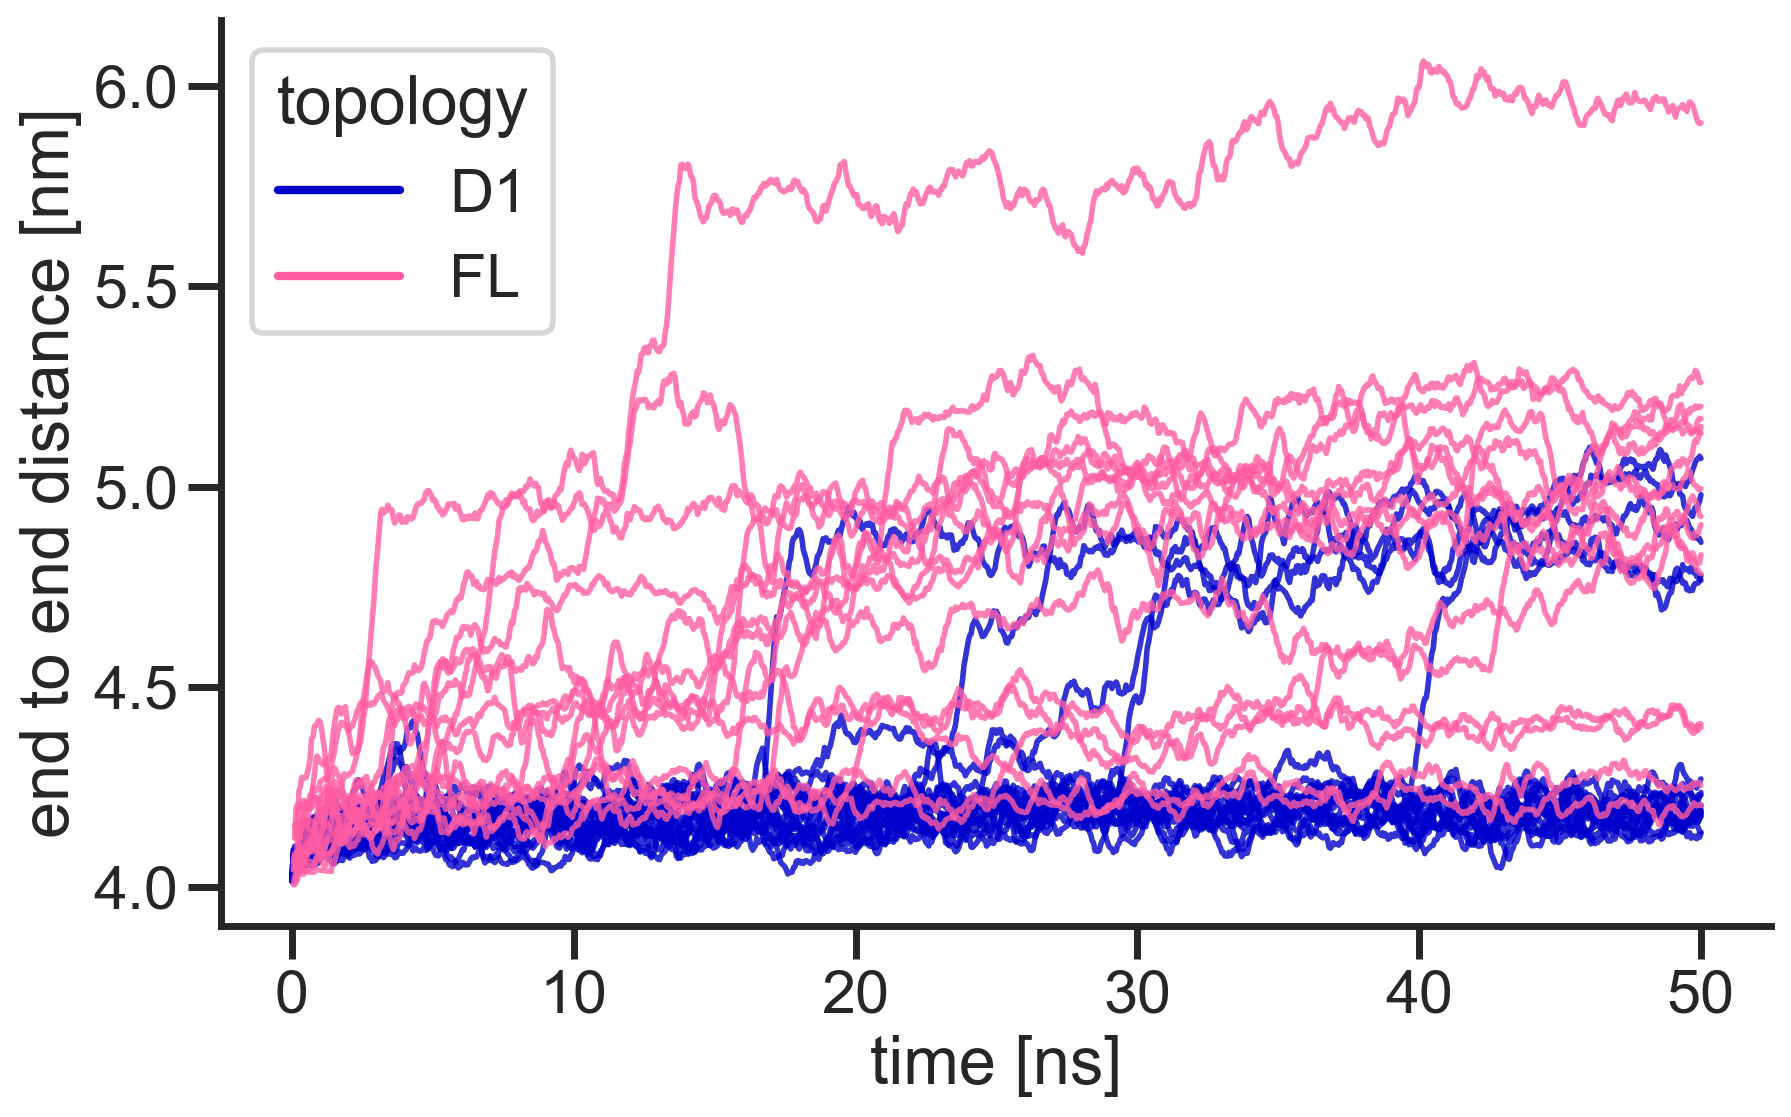

In [2]:
FORCE = 200
ROLLING_AV_SMOOTH = 10
LEGEND_OUT = False
LEGEND_TITLE = True

#loading data
data = pd.read_json("data/VBS1_pulling.json").reset_index()

#force select
data = data.loc[data['force [pN]'] == FORCE]

#smoothing with rolling avarage
data["end to end distance [nm]"] = (
    data
    .groupby(["run", "force [pN]", "topology"])["end to end distance [nm]"]
    .transform(lambda x: x.rolling(ROLLING_AV_SMOOTH, 1).mean())
)


f, ax1= plt.subplots(1,1,figsize = (10,6), dpi = 200)
g1 = sns.lineplot(data=data,
                  x='time [ns]', 
                  y="end to end distance [nm]",
                  hue='topology',
                  units='run',
                  palette=PALETTE,
                  estimator=None,
                  lw=2, 
                  alpha = 0.8,
                  ax=ax1)

if not LEGEND_TITLE:
    point_plt.legend_.set_title(None)
    
if LEGEND_OUT:
    leg = g1.legend_
    leg.set_bbox_to_anchor([1,0.7])
    
sns.despine(offset=0)

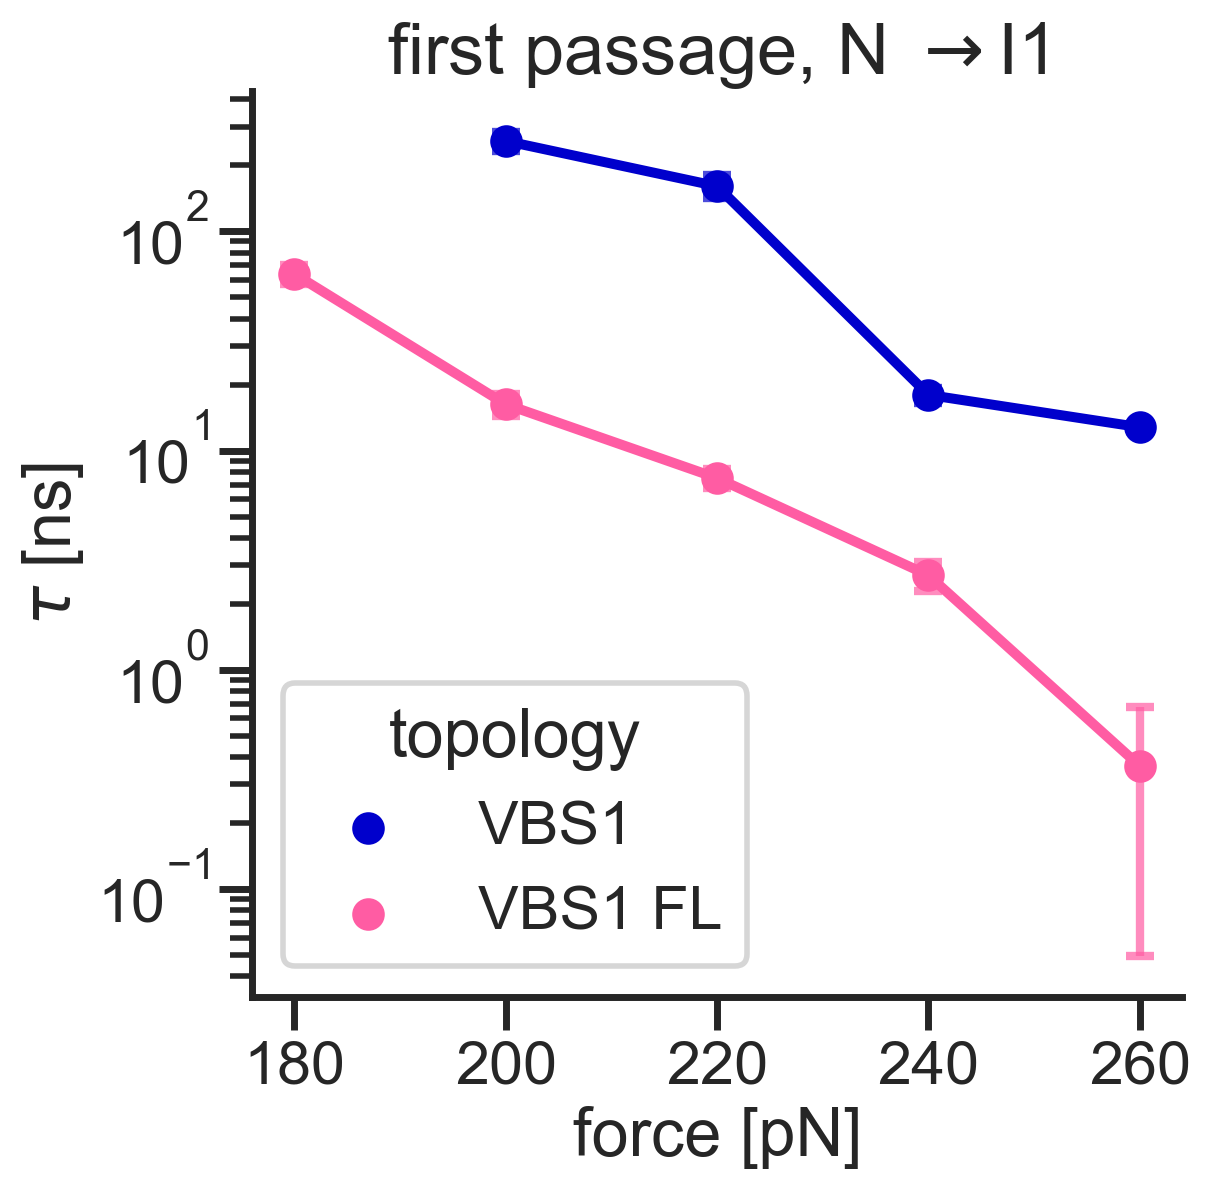

In [3]:
PASSAGE_TO_PLOT = 'first passage, N -> I1'
TITLE = f'first passage, N $\\rightarrow$I1'
TOPOLOGIES = ["VBS1", "VBS1 FL"]
LEGEND_TITLE = True
LEGEND_OUT = False

#load data
df = pd.read_json("data/fitted_passage_times.json").reset_index()
data = df.melt(id_vars=['top', 'force [pN]', 'fit to failure [ns]', 'pcov'])

# rename topology
data = data.rename(columns={"top":"topology"})

#filter topologies
data = data.loc[data['topology'].isin(TOPOLOGIES)]


fig, ax  = plt.subplots(1,1,figsize=(6,6), sharey=True, dpi=200)
with plt.rc_context({'lines.linewidth': 1}):
    point_plt = sns.pointplot(data = data.loc[(data['value']==PASSAGE_TO_PLOT)],  # &(tmp['hue']!='VBS1 FL')],
                            x='force [pN]',
                            y='fit to failure [ns]',
                            hue='topology',
                            scale=2,
                            marker='o',
                            palette=PALETTE,
                            legend_out=True,
                            ax=ax
                            )
    
# PLOT ERRORBARS (there is no neat way to do this which is correct)
lookup = pd.Series( df['pcov'].values,index=df['fit to failure [ns]']).to_dict()
lookup_force = pd.Series( df['force [pN]'].values,index=df['fit to failure [ns]']).to_dict()


for f in point_plt.collections[:]:
    color=f.get_facecolor()[0]
    ys,fs,pos=[],[],[]
    for p in f.get_offsets().data:
        x=p[0]
        y=p[1]
        try:
            y_err=lookup[p[1]]
            force=lookup_force[p[1]]
        except: 
            continue
            
        fs.append(force)
        ys.append(y)
        pos.append(x)
        ax.errorbar(x,y,np.sqrt(y_err),c =color, alpha = 0.7, lw=3, capsize=5, capthick=3 )
        
if not LEGEND_TITLE:
    point_plt.legend_.set_title(None)
    
if LEGEND_OUT:
    leg = point_plt.legend_
    leg.set_bbox_to_anchor([1,0.7])

ax.set_yscale('log')
ax.set_ylabel('$\\tau$ [ns]')
ax.set_title(TITLE, fontdict={'fontsize': 26, 'fontweight': 'medium'})
sns.despine(offset=0)
